# LangSmith and Evaluation Overview with AI Makerspace

Today we'll be looking at an amazing tool:

[LangSmith](https://docs.smith.langchain.com/)!

This tool will help us monitor, test, debug, and evaluate our LangChain applications - and more!

We'll also be looking at a few Advanced Retrieval techniques along the way - and evaluate it using LangSmith!

✋BREAKOUT ROOM #1:
- Task 1: Dependencies and OpenAI API Key
- Task 2: Basic RAG Chain
- Task 3: Setting Up LangSmith
- Task 4: Examining the Trace in LangSmith!
- Task 5: Create Testing Dataset

✋BREAKOUT ROOM #2:
- Task 1: Parent Document Retriever
- Task 2: Ensemble Retriever

## Task 1: Dependencies and OpenAI API Key

We'll be using OpenAI's suite of models today to help us generate and embed our documents for a simple RAG system built on top of LangChain's blogs!

In [7]:
!pip install langchain_core langchain_openai langchain_community langchain-qdrant qdrant-client langsmith openai tiktoken cohere -qU lxml 

In [8]:
import os
import getpass

os.environ["OPENAI_API_KEY"] = getpass.getpass("Enter your OpenAI API Key:")

## Task 2: Basic RAG Chain

Now we'll set up our basic RAG chain, first up we need a model!

### OpenAI Model


We'll use OpenAI's `gpt-3.5-turbo` model to ensure we can use a stronger model for decent evaluation later!

Notice that we can tag our resources - this will help us be able to keep track of which resources were used where later on!

In [9]:
from langchain_openai.chat_models import ChatOpenAI

base_llm = ChatOpenAI(model="gpt-3.5-turbo", tags=["base_llm"])

#### Asyncio Bug Handling

This is necessary for Colab.

In [10]:
import nest_asyncio
nest_asyncio.apply()

### SiteMap Loader

We'll use a SiteMapLoader to scrape the LangChain blogs.

In [11]:
from langchain.document_loaders import SitemapLoader

documents = SitemapLoader(web_path="https://blog.langchain.dev/sitemap-posts.xml").load() 

Fetching pages: 100%|##########| 223/223 [00:10<00:00, 20.96it/s]


In [12]:
documents[0].metadata["source"]

'https://blog.langchain.dev/jockey-twelvelabs-langgraph/'

### RecursiveCharacterTextSplitter

We're going to use a relatively naive text splitting strategy today!

In [13]:
from langchain.text_splitter import RecursiveCharacterTextSplitter

split_documents = RecursiveCharacterTextSplitter.from_tiktoken_encoder(
    chunk_size = 500,
    chunk_overlap = 20
).split_documents(documents)

In [14]:
len(split_documents)

1559

### Embeddings

We'll be leveraging OpenAI's [text-embedding-3-small](https://openai.com/index/new-embedding-models-and-api-updates/) today!

In [15]:
from langchain_openai.embeddings import OpenAIEmbeddings

base_embeddings_model = OpenAIEmbeddings(model="text-embedding-3-small")

### Qdrant VectorStore Retriever

Now we can use a Qdrant VectorStore to embed and store our documents and then convert it to a retriever so it can be used in our chain!

In [16]:
from langchain_qdrant import Qdrant

vectorstore = Qdrant.from_documents(
    split_documents,
    base_embeddings_model,
    location=":memory:",
    collection_name="langchainblogs")

In [17]:
base_retriever = vectorstore.as_retriever()

### Prompt Template

All we have left is a prompt template, which we'll create here!

In [18]:
from langchain.prompts import ChatPromptTemplate

base_rag_prompt_template = """\
Using the provided context, please answer the user's question. If you don't know the answer based on the context, say you don't know.

Context:
{context}

Question:
{question}
"""

base_rag_prompt = ChatPromptTemplate.from_template(base_rag_prompt_template)

### LCEL Chain

Now that we have:

- Embeddings Model
- Generation Model
- Retriever
- Prompt

We're ready to build our LCEL chain!

Keep in mind that we're returning our source documents with our queries - while this isn't necessary, it's a great thing to get into the habit of doing.

In [19]:
from operator import itemgetter
from langchain_core.runnables import RunnablePassthrough, RunnableParallel
from langchain.schema import StrOutputParser

base_rag_chain = (
    # INVOKE CHAIN WITH: {"question" : "<<SOME USER QUESTION>>"}
    # "question" : populated by getting the value of the "question" key
    # "context"  : populated by getting the value of the "question" key and chaining it into the base_retriever
    {"context": itemgetter("question") | base_retriever, "question": itemgetter("question")}
    # "context"  : is assigned to a RunnablePassthrough object (will not be called or considered in the next step)
    #              by getting the value of the "context" key from the previous step
    | RunnablePassthrough.assign(context=itemgetter("context"))
    # "response" : the "context" and "question" values are used to format our prompt object and then piped
    #              into the LLM and stored in a key called "response"
    # "context"  : populated by getting the value of the "context" key from the previous step
    | {"response": base_rag_prompt | base_llm | StrOutputParser(), "context": itemgetter("context")}
)

Let's test it out!

In [20]:
base_rag_chain.invoke({"question" : "What is a good way to evaluate agents?"})["response"]

"A good way to evaluate agents is by testing their capabilities in various tasks and workflows, assessing their performance in function calling, task decomposition, and the ability to override pre-trained biases when necessary. Additionally, evaluating the agent's reliability and the ability to generalize across different workflows where reasoning is required is crucial."

## Task 3: Setting Up LangSmith

Now that we have a chain - we're ready to get started with LangSmith!

We're going to go ahead and use the following `env` variables to get our Colab notebook set up to start reporting.

If all you needed was simple monitoring - this is all you would need to do!

In [21]:
from uuid import uuid4

unique_id = uuid4().hex[0:8]

os.environ["LANGCHAIN_TRACING_V2"] = "true"
os.environ["LANGCHAIN_PROJECT"] = f"LangSmith - {unique_id}"

### LangSmith API

In order to use LangSmith - you will need a beta key, you can join the queue through the `Beta Sign Up` button on LangSmith's homepage!

Join [here](https://www.langchain.com/langsmith)

In [22]:
os.environ["LANGCHAIN_API_KEY"] = getpass.getpass('Enter your LangSmith API key: ')

Let's test our our first generation!

In [23]:
base_rag_chain.invoke({"question" : "What is LangSmith?"}, {"tags" : ["Demo Run"]})['response']

'LangSmith is a unified platform for debugging, testing, evaluating, and monitoring LLM (Large Language Models) applications. It acts as an AI compass built into LangChain, guiding users through the intricate decision pathways and results generated by their chatbots.'

## Task 4: Examining the Trace in LangSmith!

Head on over to your LangSmith web UI to check out how the trace looks in LangSmith!

#### 🏗️ Activity #1:

Include a screenshot of your trace and explain what it means.

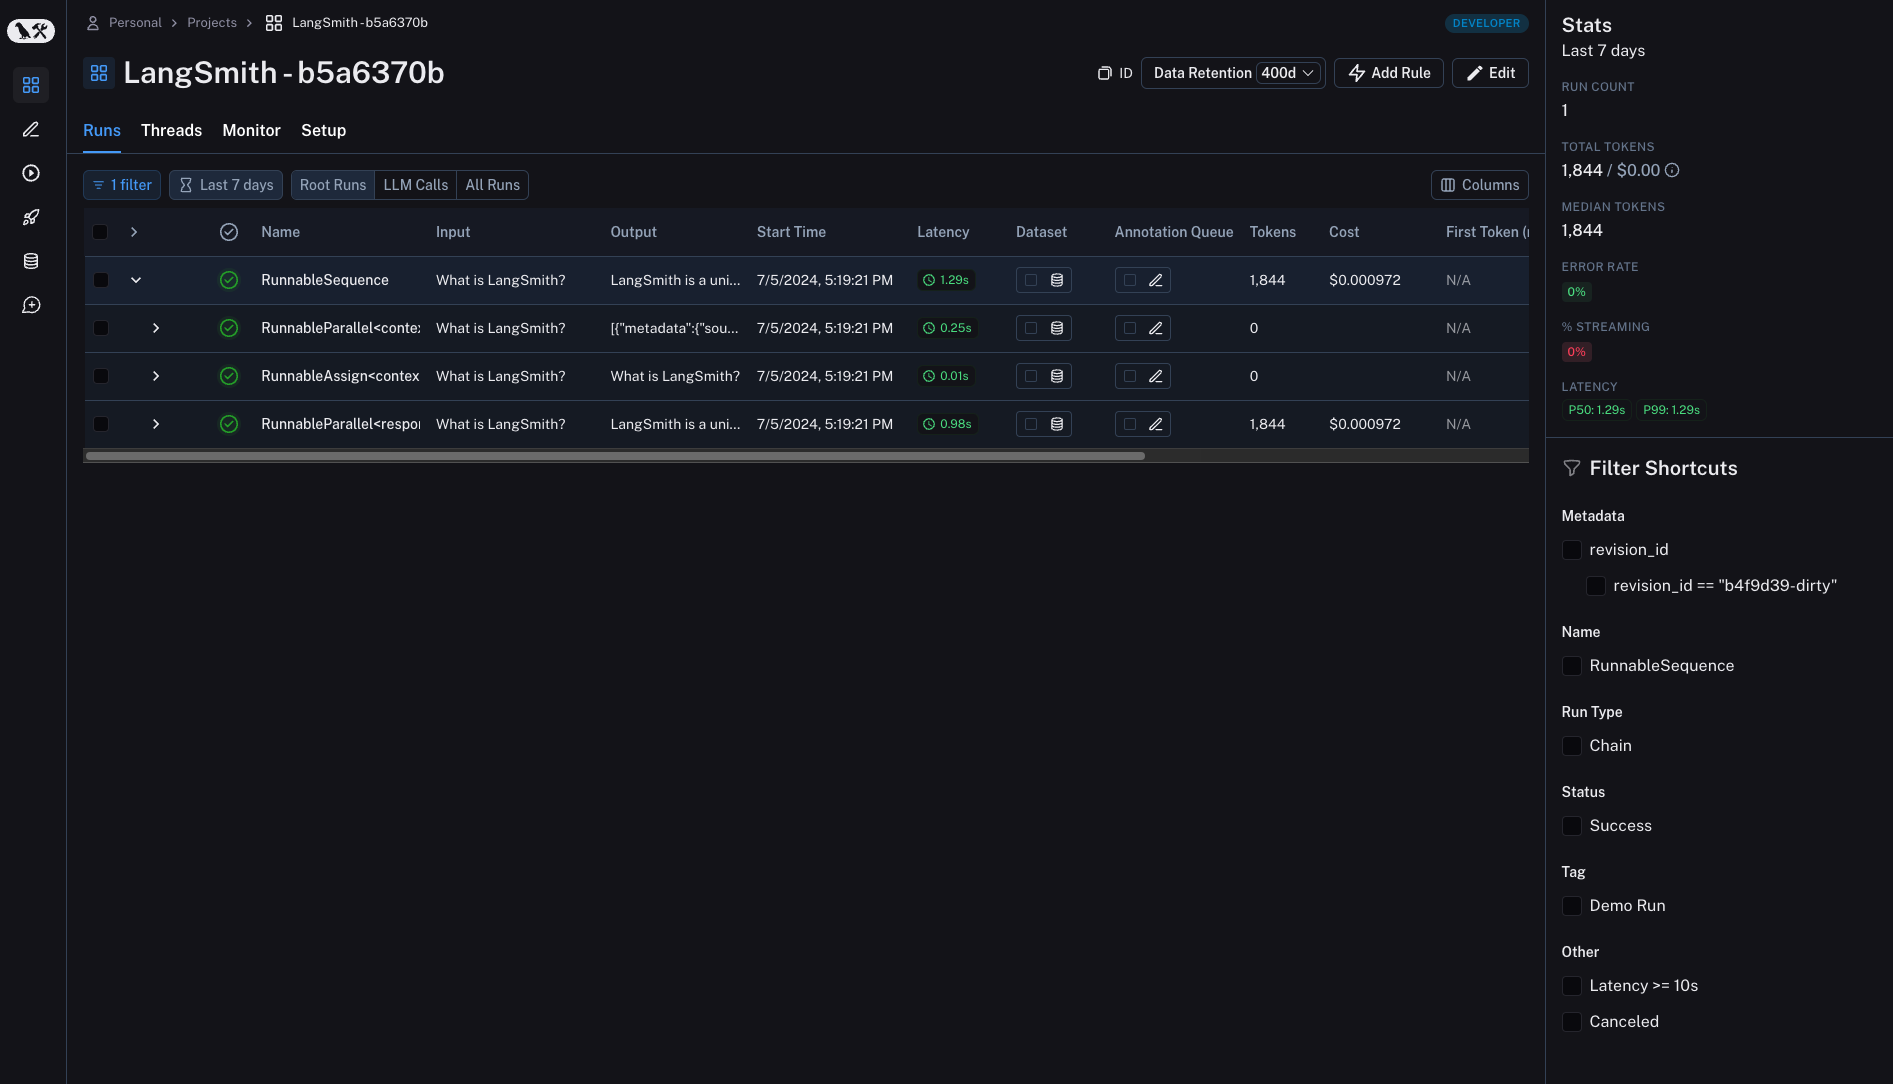

**ANSWER**
The screenshot of my trace shows the execution of my LangChain workflow which is asking the question "What is LangSmith?". The trace shows the input/output of each step in the workflow.

## Task 5: Create Testing Dataset

Now we can create a dataset using some user defined questions, and providing the retrieved context as a "ground truth" context.

> NOTE: There are many different ways you can approach this specific task - generating ground truth answers with AI, using human experts to generate golden datasets, and more!

### Synthetic Data Generation (SDG)

In order to full test our RAG chain, and the various modifications we'll be using in the following notebook, we'll need to create a small synthetic dataset that is relevant to our task!

Let's start by generating a series of questions - which begins with a simple model definition!

> NOTE: We're going to be using a purposefully simplified datagen pipeline as an example today - but you could leverage the RAGAS SDG pipeline just as easily.

In [24]:
question_model = ChatOpenAI(model="gpt-4o")

Next up, we'll create some novel chunks from our source data!

In [25]:
sdg_documents = RecursiveCharacterTextSplitter.from_tiktoken_encoder(
    chunk_size = 1000,
    chunk_overlap = 20
).split_documents(documents)

Now, let's ask some questions that could be answered from the provided chunks!

In [26]:
question_prompt_template = """\
You are a University Professor creating questions for an exam. You must create a question for a given piece of context.

The question must be answerable only using the provided context.

Avoid creating questions that are ambiguous or vague. They should be specifically related to the context.

Your output must only be the question.

Context:
{context}
"""

question_prompt = ChatPromptTemplate.from_template(question_prompt_template)

In [27]:
question_chain = question_prompt | question_model

Now we can loop through a subset of our context chunks and create question/context pairs!

In [28]:
from tqdm import tqdm
import json

question_context_pairs = []

for idx in tqdm(range(0, len(sdg_documents), 40)):
  question = question_chain.invoke({"context" : sdg_documents[idx].page_content})
  question_context_pairs.append({"question" : question.content, "context" : sdg_documents[idx].page_content, "idx" : idx})


100%|██████████| 23/23 [00:15<00:00,  1.52it/s]


In [29]:
question_context_pairs[0]

{'question': 'What technologies does Jockey, the conversational video agent, utilize for more intelligent video processing?',
 'context': 'Jockey: A Conversational Video Agent Powered by Twelve Labs APIs and LangGraph\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\nSkip to content\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\nAll Posts\n\n\n\n\nRelease Notes\n\n\n\n\nCase Studies\n\n\n\n\nIn the Loop\n\n\n\n\nLangChain\n\n\n\n\nDocs\n\n\n\n\n\nSign in\nSubscribe\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\nJockey: A Conversational Video Agent Powered by Twelve Labs APIs and LangGraph\nGuest blog post on how Jockey, a conversational video agent, uses LangGraph and Twelve Labs API for more intelligent video processing.\n\n6 min read\nJul 3, 2024',
 'idx': 0}

We'll repeat this process for answers!

In [30]:
answer_prompt_template = """\
You are a University Professor creating an exam. You must create a answer for a given piece of context and question.

The answer must only rely on the provided context.

Your output must only be the answer.

Context:
{context}
"""

answer_prompt = ChatPromptTemplate.from_template(answer_prompt_template)

In [31]:
answer_chain = answer_prompt | question_model

In [32]:
for question_context_pair in tqdm(question_context_pairs):
  question_context_pair["answer"] = answer_chain.invoke({"question" : question_context_pair["question"], "context" : question_context_pair["context"]}).content

100%|██████████| 23/23 [00:15<00:00,  1.45it/s]


In [33]:
question_context_pairs[0]

{'question': 'What technologies does Jockey, the conversational video agent, utilize for more intelligent video processing?',
 'context': 'Jockey: A Conversational Video Agent Powered by Twelve Labs APIs and LangGraph\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\nSkip to content\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\nAll Posts\n\n\n\n\nRelease Notes\n\n\n\n\nCase Studies\n\n\n\n\nIn the Loop\n\n\n\n\nLangChain\n\n\n\n\nDocs\n\n\n\n\n\nSign in\nSubscribe\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\nJockey: A Conversational Video Agent Powered by Twelve Labs APIs and LangGraph\nGuest blog post on how Jockey, a conversational video agent, uses LangGraph and Twelve Labs API for more intelligent video processing.\n\n6 min read\nJul 3, 2024',
 'idx': 0,
 'answer': 'Jockey is a conversational video agent that uses LangGraph and Twelve Labs API for more intelligent video processing.'}

Now we can set up our LangSmith client - and we'll add the above created dataset to our LangSmith instance!

> NOTE: Read more about this process [here](https://docs.smith.langchain.com/old/evaluation/faq/manage-datasets#create-from-list-of-values)

In [34]:
from langsmith import Client

client = Client()

dataset_name = "langsmith-demo-dataset-v1"

dataset = client.create_dataset(
    dataset_name=dataset_name, description="LangChain Blog Test Questions"
)

for triplet in question_context_pairs:
  client.create_example(
      inputs={"question" : triplet["question"]},
      outputs={"answer" : triplet["answer"]},
      dataset_id=dataset.id
  )

### Evaluation

Now we can run the evaluation!

We'll need to start by preparing some custom data preparation functions to ensure our chain works with the expected inputs/outputs from the `evaluate` process in LangSmith.

> NOTE: More reading on this available [here](https://docs.smith.langchain.com/how_to_guides/evaluation/evaluate_llm_application#evaluate-a-langchain-runnable)

In [36]:
def prepare_data_ref(run, example):
  return {
      "prediction" : run.outputs["response"],
      "reference" : example.outputs["answer"],
      "input" : example.inputs["question"]
  }

def prepare_data_noref(run, example):
  return {
      "prediction" : run.outputs["response"],
      "input" : example.inputs["question"]
  }

We'll be using a few custom evaluators to evaluate our pipeline, as well as a few "built in" methods!

Check out the built-ins [here](https://docs.smith.langchain.com/reference/sdk_reference/langchain_evaluators)!

In [37]:
from langsmith.evaluation import LangChainStringEvaluator, evaluate

cot_qa_evaluator = LangChainStringEvaluator("cot_qa", prepare_data=prepare_data_ref)

unlabeled_dopeness_evaluator = LangChainStringEvaluator(
    "criteria",
    config={
        "criteria" : {
            "dopeness" : "Is the answer to the question dope, meaning cool - awesome - and legit?"
        }
    },
    prepare_data=prepare_data_noref
)

labeled_score_evaluator = LangChainStringEvaluator(
    "labeled_score_string",
    config={
        "criteria": {
            "accuracy": "Is the generated answer the same as the reference answer?"
        },
    },
    prepare_data=prepare_data_ref
)

unlabeled_coherence_evaluator = LangChainStringEvaluator("criteria", config={"criteria": "coherence"}, prepare_data=prepare_data_noref)
labeled_relevance_evaluator = LangChainStringEvaluator("labeled_criteria", config={ "criteria": "relevance"}, prepare_data=prepare_data_ref)

base_rag_results = evaluate(
    base_rag_chain.invoke,
    data=dataset_name,
    evaluators=[
        cot_qa_evaluator,
        unlabeled_dopeness_evaluator,
        labeled_score_evaluator,
        unlabeled_coherence_evaluator,
        labeled_relevance_evaluator
        ],
    experiment_prefix="Base RAG Evaluation"
)

View the evaluation results for experiment: 'Base RAG Evaluation-c16bef70' at:
https://smith.langchain.com/o/714854c2-ce6e-569c-ad34-f7d8c9bd8b70/datasets/f52a16d1-3829-402f-9ed5-e88d4f270d5d/compare?selectedSessions=344ace68-6724-498c-be5f-e2dd15e17079




0it [00:00, ?it/s]

## Testing Other Retrievers

Now we can test our how changing our Retriever impacts our LangSmith evaluation!

We'll build this simple qa_chain factory to create standardized qa_chains where the only different component will be the retriever.

In [38]:
def create_qa_chain(retriever):
  primary_qa_llm = ChatOpenAI(model_name="gpt-3.5-turbo", temperature=0)
  created_qa_chain = (
    {"context": itemgetter("question") | retriever,
     "question": itemgetter("question")
    }
    | RunnablePassthrough.assign(
        context=itemgetter("context")
      )
    | {
         "response": base_rag_prompt | primary_qa_llm,
         "context": itemgetter("context"),
      }
  )
  return created_qa_chain

### Task 1: Parent Document Retriever

One of the easier ways we can imagine improving a retriever is to embed our documents into small chunks, and then retrieve a significant amount of additional context that "surrounds" the found context.

You can read more about this method [here](https://python.langchain.com/docs/modules/data_connection/retrievers/parent_document_retriever)!

The basic outline of this retrieval method is as follows:

1. Obtain User Question
2. Retrieve child documents using Dense Vector Retrieval
3. Merge the child documents based on their parents. If they have the same parents - they become merged.
4. Replace the child documents with their respective parent documents from an in-memory-store.
5. Use the parent documents to augment generation.

In [39]:
from langchain.retrievers import ParentDocumentRetriever
from langchain.storage import InMemoryStore
from qdrant_client import QdrantClient
from qdrant_client.models import Distance, VectorParams

client = QdrantClient(":memory:")
client.create_collection(
    collection_name="split_parents",
    vectors_config=VectorParams(size=1536, distance=Distance.COSINE),
)

vectorstore = Qdrant(client, collection_name="split_parents", embeddings=base_embeddings_model)

store = InMemoryStore()

In [40]:
parent_document_retriever = ParentDocumentRetriever(
    vectorstore=vectorstore,
    docstore=store,
    child_splitter=RecursiveCharacterTextSplitter(chunk_size=400),
    parent_splitter=RecursiveCharacterTextSplitter(chunk_size=2000),
)

In [41]:
parent_document_retriever.add_documents(documents)

Let's create, test, and then evaluate our new chain!

In [42]:
parent_document_retriever_qa_chain = create_qa_chain(parent_document_retriever)

In [43]:
parent_document_retriever_qa_chain.invoke({"question" : "What is RAG?"})["response"].content

'RAG stands for Retrieval Augmented Generation, which is a central paradigm in Large Language Model (LLM) application development. It involves connecting LLMs to external data sources to provide recent and private information for training and generating answers based on retrieved context.'

#### Evaluating the Parent Document Retrieval Pipeline

Now that we've created a new retriever - let's try evaluating it on the same dataset!

In [46]:
# Calling the chain again with the new retriever with the same evaluators
pdr_rag_results = evaluate(
    parent_document_retriever_qa_chain.invoke,
    data=dataset_name,
    evaluators=[
        cot_qa_evaluator,
        unlabeled_dopeness_evaluator,
        labeled_score_evaluator,
        unlabeled_coherence_evaluator,
        labeled_relevance_evaluator
        ],
    experiment_prefix="Parent Document Retrieval RAG Evaluation"
)

View the evaluation results for experiment: 'Parent Document Retrieval RAG Evaluation-89470f96' at:
https://smith.langchain.com/o/714854c2-ce6e-569c-ad34-f7d8c9bd8b70/datasets/f52a16d1-3829-402f-9ed5-e88d4f270d5d/compare?selectedSessions=d6db90c6-6c34-4bb3-af50-597cd6311e52




0it [00:00, ?it/s]

### Task 2: Ensemble Retrieval

Next let's look at ensemble retrieval!

You can read more about this [here](https://python.langchain.com/docs/modules/data_connection/retrievers/ensemble)!

The basic idea is as follows:

1. Obtain User Question
2. Hit the Retriever Pair
    - Retrieve Documents with BM25 Sparse Vector Retrieval
    - Retrieve Documents with Dense Vector Retrieval Method
3. Collect and "fuse" the retrieved docs based on their weighting using the [Reciprocal Rank Fusion](https://plg.uwaterloo.ca/~gvcormac/cormacksigir09-rrf.pdf) algorithm into a single ranked list.
4. Use those documents to augment our generation.

Ensure your `weights` list - the relative weighting of each retriever - sums to 1!

In [47]:
!pip install -q -U rank_bm25 

In [48]:
from langchain.retrievers import BM25Retriever, EnsembleRetriever

text_splitter = RecursiveCharacterTextSplitter(chunk_size=450, chunk_overlap=75)
split_documents = text_splitter.split_documents(documents)

bm25_retriever = BM25Retriever.from_documents(split_documents)
bm25_retriever.k = 2

embedding = OpenAIEmbeddings()
vectorstore = Qdrant.from_documents(split_documents, embedding, location=":memory:")
qdrant_retriever = vectorstore.as_retriever(search_kwargs={"k": 3})

ensemble_retriever = EnsembleRetriever(
    retrievers=[
        bm25_retriever,
        qdrant_retriever
    ],
    weights=[
        0.5,
        0.5
    ])

In [49]:
ensemble_retriever_qa_chain = create_qa_chain(ensemble_retriever)

In [50]:
ensemble_retriever_qa_chain.invoke({"question" : "What is RAG?"})["response"].content

'RAG stands for Retrieval Augmented Generation. It is a central paradigm in LLM (Large Language Model) application development that connects LLMs to external data sources to address the lack of recent or private information in the models.'

In [51]:
pdr_rag_results = evaluate(
    ensemble_retriever_qa_chain.invoke,
    data=dataset_name,
    evaluators=[
        cot_qa_evaluator,
        unlabeled_dopeness_evaluator,
        labeled_score_evaluator,
        unlabeled_coherence_evaluator,
        labeled_relevance_evaluator
        ],
    experiment_prefix="Hybrid Retrieval RAG Evaluation"
)

View the evaluation results for experiment: 'Hybrid Retrieval RAG Evaluation-251eaae0' at:
https://smith.langchain.com/o/714854c2-ce6e-569c-ad34-f7d8c9bd8b70/datasets/f52a16d1-3829-402f-9ed5-e88d4f270d5d/compare?selectedSessions=0202e4d1-60a6-4da3-bbb1-d1388d0177fd




0it [00:00, ?it/s]

Error running evaluator <DynamicRunEvaluator evaluate> on run 03cc74aa-7345-4be9-b789-246a7a7ae965: ValueError('Invalid output: The assistant\'s response is not accurate because it does not provide any names starting with the letter "H" from the provided context. However, it\'s important to note that the context itself is not provided in this evaluation, making it impossible to determine if there were any names starting with "H" to begin with. The assistant\'s response of "I don\'t know" could potentially be accurate if there were no names starting with "H" in the context. Without the context, it\'s impossible to accurately rate the assistant\'s response. Rating: [[N/A]]. Output must contain a double bracketed string                 with the verdict between 1 and 10.')
Traceback (most recent call last):
  File "/opt/miniconda3/envs/AIE3/lib/python3.11/site-packages/langsmith/evaluation/_runner.py", line 1233, in _run_evaluators
    evaluator_response = evaluator.evaluate_run(
         

#### ❓Question #1:

What conclusions can you draw about the above results?

Describe in your own words what the metrics are expressing.

**ANSWER**

It looks like more advanced retriever methods equate to more coherent and dopeness scores. The base RAG evaluation did however, have the overall better score. I think what is clear is that this dataset is too small and my hunch is that improved retrievers may yield better results. 

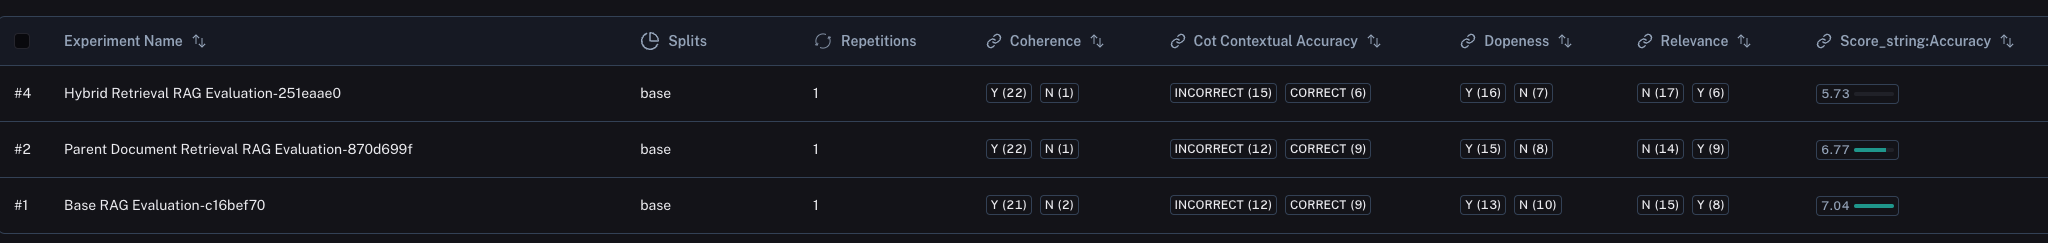